## 1.generate 2-dimensional data

#### use make_moons generate inital data

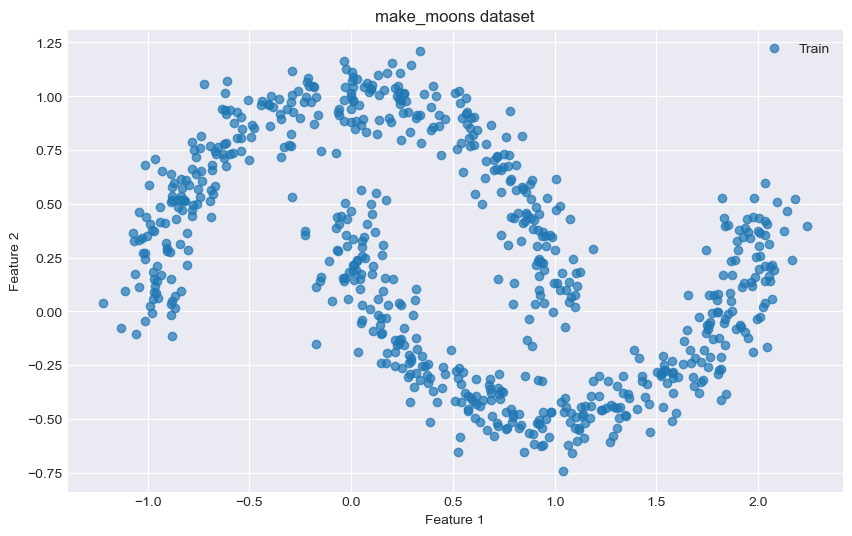

In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree # KD树
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal # 计算高斯密度
from matplotlib.patches import Ellipse # 可视化GMM
from scipy.spatial.distance import cdist  # MMD计算需要


plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-v0_8-darkgrid')



# generate dataset
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)  # noise 0.1
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# visualize the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.7, label="Train")
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', alpha=0.8, label="Test")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.legend()
plt.show()


## 2.compare 4 density estimation methods

#### 2.1 Histogram

In [2]:
#  直方图 类
class Histogram:
    """
    二维直方图密度估计，使用 IQR-Freedman-Diaconis 法自动选择 bin 宽度。
    """
    def __init__(self, n_bins=None):
        self.n_bins = n_bins
        self.n_samples = None
        self.bins_x = None
        self.bins_y = None
        self.bin_width_x = None
        self.bin_width_y = None
        self.density_values = None
        self.bin_area = None
        

    def fit(self, X):
        self.X = X
        self.n_samples = X.shape[0]
        
        self._compute_bins(X)
        self._compute_density()

        return self 

    def _compute_bins(self, X):
        # 按每个维度分别计算 IQR, bin宽度 & bin分界点
        n =self.n_samples
        if self.n_bins is not None:
            x_min, x_max = X[:,0].min(), X[:,0].max()
            y_min, y_max = X[:,1].min(), X[:,1].max()
            # 使用指定的bin数
            self.bins_x = np.linspace(x_min, x_max, self.n_bins+1)
            self.bins_y = np.linspace(y_min, y_max, self.n_bins+1)
            self.bin_width_x = (x_max - x_min) / self.n_bins
            self.bin_width_y = (y_max - y_min) / self.n_bins
            print(f"使用固定bin数: {self.n_bins} x {self.n_bins}")
        else:
            def _edges(data,n_samples):
                q1, q3 = np.percentile(data, [25, 75])
                iqr = q3 - q1
                h = 2 * iqr / (n_samples ** (1/3))
                if h == 0:
                    h = 1e-5  # 极端情况保护

                data_min, data_max = data.min(), data.max()
                # bin数量 向上取整
                M = int(np.ceil((data_max - data_min) / h))

                print(f"Computed bin width: {h}, Number of bins: {M}")
                # 生成分界点（edges），一共M+1个
                edges = np.linspace(data_min, data_max, M+1)
                return edges, h
            self.bins_x, self.bin_width_x = _edges(self.X[:,0], n)
            self.bins_y, self.bin_width_y = _edges(self.X[:,1], n)

        self.bin_area = self.bin_width_x * self.bin_width_y
        if self.bin_area == 0:
            self.bin_area = 1e-10


    def _compute_density(self):
        # 统计每个bin的点数 & 归一化
        counts, _, _ = np.histogram2d(self.X[:,0], self.X[:,1], bins=[self.bins_x, self.bins_y])
        area = self.bin_width_x * self.bin_width_y
        # 概率密度（概率密度指每个小格内每单位面积概率）
        self.density_values = counts / (self.n_samples * self.bin_area)



    def sample(self, num_samples):
        # 按密度分布采样
        flat_density = self.density_values.flatten()

        flat_density /= flat_density.sum()  # 归一化为概率分布
        chosen_bins = np.random.choice(len(flat_density), size=num_samples, p=flat_density)
        samples = []


        for bin_idx in chosen_bins:
            #找到xy方向的bin索引
            bin_x_idx = bin_idx // self.density_values.shape[1]
            bin_y_idx = bin_idx % self.density_values.shape[1]

            #找到bin的边界，均匀采样
            x_low = self.bins_x[bin_x_idx]
            x_high = self.bins_x[bin_x_idx + 1]
            y_low = self.bins_y[bin_y_idx]
            y_high = self.bins_y[bin_y_idx + 1]

            #在bin内均匀采样
            sample_x = np.random.uniform(x_low, x_high)
            sample_y = np.random.uniform(y_low, y_high)
            samples.append([sample_x, sample_y])
        return np.array(samples)
    


    def density_estimate(self, X):
        # 计算给定点的密度估计
        densities = []
        for x, y in X:
            bin_x_idx = np.digitize(x, self.bins_x) - 1
            bin_y_idx = np.digitize(y, self.bins_y) - 1
            # 边界处理
            bin_x_idx = np.clip(bin_x_idx, 0, self.density_values.shape[0]-1)
            bin_y_idx = np.clip(bin_y_idx, 0, self.density_values.shape[1]-1)

            densities.append(self.density_values[bin_x_idx, bin_y_idx])
        return np.array(densities)
    
    def score_samples(self, X):  
        """返回对数密度"""
        densities = self.density_estimate(X)
        return np.log(densities + 1e-10)

    def plot_density(self, X_data=None):
        """
        绘制 2D 密度热图 (使用 pcolormesh)。
        """
        if self.density_values is None:
            print("必须在绘图前调用 fit()。")
            return

        plt.figure(figsize=(8, 6))
        
        # pcolormesh 需要网格边界
        Xgrid, Ygrid = np.meshgrid(self.bins_x, self.bins_y)
        
        # density_values shape 是 (M_x, M_y)
        # pcolormesh 期望 Z 的 shape (M_y, M_x), 所以用 .T
        plt.pcolormesh(Xgrid, Ygrid, self.density_values.T, cmap='viridis', shading='auto')
        plt.colorbar(label='Density Estimate')

        # 绘制原始数据点
        if X_data is not None:
            plt.scatter(X_data[:, 0], X_data[:, 1], c='white', s=5, alpha=0.3, label="Data")
            plt.legend()
            
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('2D Histogram Density (IQR-FD Rule)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('equal')
        plt.show()







#### 2.2 Single Gaussian model

In [3]:
# 单二维高斯密度估计 类

class SingleGaussian:
    """
    单二维高斯密度估计算法
    原理：用所有数据拟合一个二维正态分布，然后用公式计算每一点的密度。
    """

    def __init__(self):
        self.mu = None  # 均值向量
        self.cov = None  # 协方差矩阵
        self.cov_inv = None  # 协方差矩阵的逆
        self.cov_det = None  # 协方差矩阵的行列式
        self.const = None  # 归一化常数
        self.dim = 2  # 数据维度




    def fit(self, X):
        """
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self.dim = X.shape[1]
        self.mu = np.mean(X, axis=0)  # 均值（2维）
        self.cov = np.cov(X, rowvar=False)  # 协方差矩阵（2x2）
        self.cov_inv = np.linalg.inv(self.cov)
        self.cov_det = np.linalg.det(self.cov)
        self.const = 1.0 / (2 * np.pi * np.sqrt(self.cov_det))  # 归一化系数
        return self

    def sample(self, num_samples):
        """
        从拟合的高斯分布中采样
        参数:
            num_samples: 采样数量
        返回:
            samples: 采样点 (num_samples, 2)
        """
        samples = np.random.multivariate_normal(self.mu, self.cov, size=num_samples)
        return samples
    
    def density(self, X):
        """
        计算给定点的密度值
        参数:
            X: 待评估点 (n_samples, 2)
        返回:
            densities: 密度值 (n_samples,)
        """
        X = np.atleast_2d(X)
        diff = X - self.mu  # (n_samples, 2)

        exponent = -0.5 * np.sum(diff @ self.cov_inv * diff, axis=1)  # (n_samples,)
        densities = self.const * np.exp(exponent)
        return densities

    def score_samples(self, X):  
        """返回对数密度"""
        densities = self.density(X)
        return np.log(densities + 1e-10)

    def plot_density(self, X_data=None, n_grid=100):
        """
        可视化密度分布
        """
        # 生成网格
        x = np.linspace(self.mu[0]-3*np.sqrt(self.cov[0,0]), self.mu[0]+3*np.sqrt(self.cov[0,0]), n_grid)
        y = np.linspace(self.mu[1]-3*np.sqrt(self.cov[1,1]), self.mu[1]+3*np.sqrt(self.cov[1,1]), n_grid)
        Xgrid, Ygrid = np.meshgrid(x, y)
        grid_points = np.c_[Xgrid.ravel(), Ygrid.ravel()]


        densities = self.density(grid_points)
        Z = densities.reshape(Xgrid.shape)
        plt.figure(figsize=(8,6))
        plt.contourf(Xgrid, Ygrid, Z, levels=20, cmap='viridis')
        plt.colorbar(label='Density')

        # 绘制原始数据点
        if X_data is not None:
            plt.scatter(X_data[:, 0], X_data[:, 1], c='white', s=5, alpha=0.3, label="Data")
            plt.legend()


        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Single Gaussian Density Estimate')
        plt.axis('equal')
        plt.show()





#### 2.3 GMM

In [4]:
class GaussianMixtureModel:
    """
    高斯混合模型（GMM）
    
    假设数据来自K个高斯分布的混合,使用EM算法估计参数。
    """
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        """
        参数:
            n_components: 高斯分量数量
            max_iter: 最大迭代次数
            tol: 收敛阈值
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None  # 混合权重
        self.means = None    # 均值
        self.covs = None     # 协方差矩阵
        
    def _initialize(self, X):
        """随机初始化参数"""
        n_samples, n_features = X.shape
        
        # 随机选择K个点作为初始均值
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        
        # 初始化协方差为单位矩阵
        self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # 初始化权重为均等
        self.weights = np.ones(self.n_components) / self.n_components
    

    
    def _e_step(self, X):
        """E步：计算后验概率（责任）"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            rv = multivariate_normal(self.means[k], self.covs[k])
            responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        
        # 归一化
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) + 1e-10
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """M步：更新参数"""
        n_samples, n_features = X.shape
        
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum()
            
            # 更新权重
            self.weights[k] = total_resp / n_samples
            
            # 更新均值
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
            
            # 更新协方差
            diff = X - self.means[k]
            self.covs[k] = (resp_k[:, np.newaxis] * diff).T @ diff / total_resp
            
            # 添加正则化防止奇异矩阵
            self.covs[k] += np.eye(n_features) * 1e-6
    
    def _compute_log_likelihood(self, X):
        """计算对数似然"""
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for i in range(n_samples):
            likelihood = 0 #p(x_n)
            for k in range(self.n_components):
                rv = multivariate_normal(self.means[k], self.covs[k])
                likelihood += self.weights[k] * rv.pdf(X[i])
            log_likelihood += np.log(likelihood + 1e-10)
        
        return log_likelihood
    
    def fit(self, X):
        """
        训练模型（EM算法）
        
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self._initialize(X)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iter):
            # E步
            responsibilities = self._e_step(X)
            
            # M步
            self._m_step(X, responsibilities)
            
            # 计算对数似然
            log_likelihood = self._compute_log_likelihood(X)
            
            # 检查收敛
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"GMM收敛于第{iteration + 1}次迭代")
                break
            
            log_likelihood_old = log_likelihood
        
        return self
    
    def density(self, X):
        """
        计算样本的密度值
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            density: 密度值
        """
        n_samples = X.shape[0]
        densities = np.zeros(n_samples)
        
        for i in range(n_samples):
            density = 0
            for k in range(self.n_components):
                rv = multivariate_normal(self.means[k], self.covs[k])
                density += self.weights[k] * rv.pdf(X[i])
            densities[i] = density
        
        return densities
    

    def log_density(self, X):
        """
        计算样本的对数密度
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            log_density: 对数密度
        """
        n_samples = X.shape[0]
        log_densities = np.zeros(n_samples)
        
        for i in range(n_samples):
            density = 0
            for k in range(self.n_components):
                rv = multivariate_normal(self.means[k], self.covs[k])
                density += self.weights[k] * rv.pdf(X[i])
            log_densities[i] = np.log(density + 1e-10)
        
        return log_densities
    
    def score_samples(self, X):
        """返回对数密度"""
        return self.log_density(X)

    def sample(self, n_samples):
        """
        从模型生成样本
        
        参数:
            n_samples: 生成样本数
        返回:
            samples: 生成的样本 (n_samples, 2)
        """
        samples = np.zeros((n_samples, 2))
        
        # 根据权重选择分量
        component_indices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )
        
        for i, k in enumerate(component_indices):
            samples[i] = np.random.multivariate_normal(self.means[k], self.covs[k])
        
        return samples



#### 2.4 KDE

In [5]:
class KernelDensityEstimator:
    """
    核密度估计（KDE）
    
    原理：在每个数据点放置一个核函数（高斯核），所有核的叠加构成密度估计。
    """
    def __init__(self, bandwidth=0.3):
        """
        参数:
            bandwidth: 带宽参数（控制平滑程度）
        """
        self.bandwidth = bandwidth
        self.X_train = None
        
    def fit(self, X):
        """
        训练模型（存储训练数据）
        
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self.X_train = X
        return self
    
    def score_samples(self, X):
        """
        计算样本的对数密度
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            log_density: 对数密度
        """
        n_samples, n_features = X.shape
        n_train = self.X_train.shape[0]
        
        densities = np.zeros(n_samples)
        
        for i in range(n_samples):
            # 计算所有训练点到当前点的贡献
            diff = self.X_train - X[i]
            # 高斯核: exp(-0.5 * ||x||^2 / h^2)
            kernel_values = np.exp(-0.5 * np.sum(diff**2, axis=1) / self.bandwidth**2)
            densities[i] = kernel_values.sum()
        
        # 归一化
        normalization = n_train * (2 * np.pi * self.bandwidth**2) ** (n_features / 2)
        densities = densities / normalization
        
        return np.log(densities + 1e-10)
    
    def sample(self, n_samples):
        """
        从模型生成样本
        
        参数:
            n_samples: 生成样本数
        返回:
            samples: 生成的样本 (n_samples, 2)
        """
        # 随机选择训练点
        indices = np.random.choice(self.X_train.shape[0], size=n_samples)
        base_samples = self.X_train[indices]
        
        # 添加高斯噪声
        noise = np.random.normal(0, self.bandwidth, size=(n_samples, 2))
        samples = base_samples + noise
        
        return samples
    
    def density(self, X):
        """
        计算样本的密度值
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            density: 密度值
        """
        log_densities = self.score_samples(X)
        return np.exp(log_densities)

# 测试KDE模型
#kde_model = KernelDensityEstimator(bandwidth=0.3)
#kde_model.fit(X_train)
#print(f"KDE模型训练完成，带宽: {kde_model.bandwidth}")

### 3. MMD（最大均值差异）评估

In [6]:
def squared_exponential_kernel(X, Y, h=0.1):
    """
    Squared Exponential (SE) 核
    se(x, x') = exp(-||x - x'||² / h²)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-dists / (h ** 2))

def inverse_multiquadric_kernel(X, Y, h=0.1):
    """
    Inverse Multi-Quadratic (IMQ) 核
    imq(x, x') = 1 / √(1 + ||x - x'||² / h²)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return 1.0 / np.sqrt(1 + dists / (h ** 2))

def compute_mmd(X, Y, kernel='se', **kernel_params):
    """
    计算MMD（最大均值差异）
    
    参数:
        X: 第一个样本集 (n_samples_X, n_features)
        Y: 第二个样本集 (n_samples_Y, n_features)
        kernel: 核函数类型 ('se' 或 'imq')
        **kernel_params: 核函数参数
    返回:
        mmd: MMD值
    """
    if kernel == 'se':
        K_XX = squared_exponential_kernel(X, X, **kernel_params)
        K_YY = squared_exponential_kernel(Y, Y, **kernel_params)
        K_XY = squared_exponential_kernel(X, Y, **kernel_params)
    elif kernel == 'imq':
        K_XX = inverse_multiquadric_kernel(X, X, **kernel_params)
        K_YY = inverse_multiquadric_kernel(Y, Y, **kernel_params)
        K_XY = inverse_multiquadric_kernel(X, Y, **kernel_params)
    else:
        raise ValueError(f"未知的核函数: {kernel}")
    
    # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
    n = X.shape[0]
    m = Y.shape[0]
    
    mmd_squared = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    mmd_squared += (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    mmd_squared -= 2 * K_XY.sum() / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))

# 测试MMD
X_sample = X_train[:500]
Y_sample = X_test[:500]

mmd_se = compute_mmd(X_test, Y_sample, kernel='se', h=0.1)
mmd_imq = compute_mmd(X_test, Y_sample, kernel='imq', h=0.1)

print(f"测试集间MMD (SE核): {mmd_se:.4f}")
print(f"测试集间MMD (反多二次核): {mmd_imq:.4f}")

测试集间MMD (SE核): 0.0000
测试集间MMD (反多二次核): 0.0000


### 4.evaluation models

In [7]:
def evaluate_model(model, X_test, n_samples=1000, model_name="Model"):
    """
    评估模型：生成样本并计算MMD
    
    参数:
        model: 密度模型
        X_test: 测试集
        n_samples: 生成样本数
        model_name: 模型名称
    返回:
        results: 包含MMD值的字典
    """
    # 生成样本
    X_generated = model.sample(n_samples)
    
    # 计算MMD
    mmd_se = compute_mmd(X_test, X_generated, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_generated, kernel='imq', h=0.1)

    results = {
        'model': model_name,
        'mmd_se': mmd_se,
        'mmd_imq': mmd_imq,
        'samples': X_generated
    }
    
    print(f"{model_name}:")
    print(f"  MMD (SE核): {mmd_se:.4f}")
    print(f"  MMD (IMQ核): {mmd_imq:.4f}")

    return results



In [8]:
if __name__ == "__main__":
    
    # 1. 加载和准备数据
    X, y = make_moons(n_samples=2000, noise=0.1, random_state=42)
    X_train, X_test = train_test_split(X, test_size=0.5, random_state=42)
    print(f"数据加载: X_train shape {X_train.shape}, X_test shape {X_test.shape}")

    # 2. 实例化所有模型 (使用固定的超参数)
    print("\n: 实例化模型...")
    hist_model = Histogram()
    sg_model = SingleGaussian() 
    gmm_model = GaussianMixtureModel(n_components=4, max_iter=100) # (固定超参数)
    kde_model = KernelDensityEstimator(bandwidth=0.1) # (固定超参数)

    models_to_train = {
        "直方图": hist_model,
        "单高斯": sg_model,
        "GMM (k=4)": gmm_model,
        "KDE (h=0.1)": kde_model
    }

    # 3. 训练所有模型
    print("\n: 正在训练模型...")
    for name, model in models_to_train.items():
        print(f"  正在训练 {name}...")
        model.fit(X_train)
    print("所有模型训练完成。")

    # 4. 评估所有模型
    print("\n: 正在评估模型 (计算MMD)...")
    results = []
    
    for name, model in models_to_train.items():
        results.append(
            evaluate_model(model, X_test, n_samples=X_test.shape[0], model_name=name)
        )

 


    # 测试：单高斯应该和单分量GMM给出相同结果
    print("\n验证：Single Gaussian vs GMM(K=1)")
    sg_test = SingleGaussian().fit(X_train)
    gmm_test = GaussianMixtureModel(n_components=1, max_iter=100).fit(X_train)

    # 在测试点上比较密度
    test_points = X_test[:10]
    sg_density = np.exp(sg_test.score_samples(test_points))
    gmm_density = np.exp(gmm_test.score_samples(test_points))

    print(f"Single Gaussian 密度: {sg_density[:3]}")
    print(f"GMM(K=1) 密度: {gmm_density[:3]}")
    print(f"差异 (应该很小): {np.abs(sg_density - gmm_density).max():.6f}")

    # 5. 找到最好的模型
    best_model_se = min(results, key=lambda r: r['mmd_se'])
    best_model_imq = min(results, key=lambda r: r['mmd_imq'])

    print(f"SE 核的最佳模型: {best_model_se['model']} (MMD: {best_model_se['mmd_se']:.4f})")
    print(f"IMQ 核的最佳模型: {best_model_imq['model']} (MMD: {best_model_imq['mmd_imq']:.4f})")


数据加载: X_train shape (1000, 2), X_test shape (1000, 2)

: 实例化模型...

: 正在训练模型...
  正在训练 直方图...
Computed bin width: 0.23505994648681955, Number of bins: 15
Computed bin width: 0.1777667401477554, Number of bins: 12
  正在训练 单高斯...
  正在训练 GMM (k=4)...
GMM收敛于第87次迭代
  正在训练 KDE (h=0.1)...
所有模型训练完成。

: 正在评估模型 (计算MMD)...
直方图:
  MMD (SE核): 0.0364
  MMD (IMQ核): 0.0391
单高斯:
  MMD (SE核): 0.0892
  MMD (IMQ核): 0.1263
GMM (k=4):
  MMD (SE核): 0.0492
  MMD (IMQ核): 0.0616
KDE (h=0.1):
  MMD (SE核): 0.0277
  MMD (IMQ核): 0.0280

验证：Single Gaussian vs GMM(K=1)
GMM收敛于第2次迭代
Single Gaussian 密度: [0.10887827 0.154789   0.12227616]
GMM(K=1) 密度: [0.10884554 0.15479662 0.12225341]
差异 (应该很小): 0.000321
SE 核的最佳模型: KDE (h=0.1) (MMD: 0.0277)
IMQ 核的最佳模型: KDE (h=0.1) (MMD: 0.0280)


### 5.1 density visualization

/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/476806589.py:73: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/476806589.py:73: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/476806589.py:73: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/476806589.py:73: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/476806589.py:73: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipyker

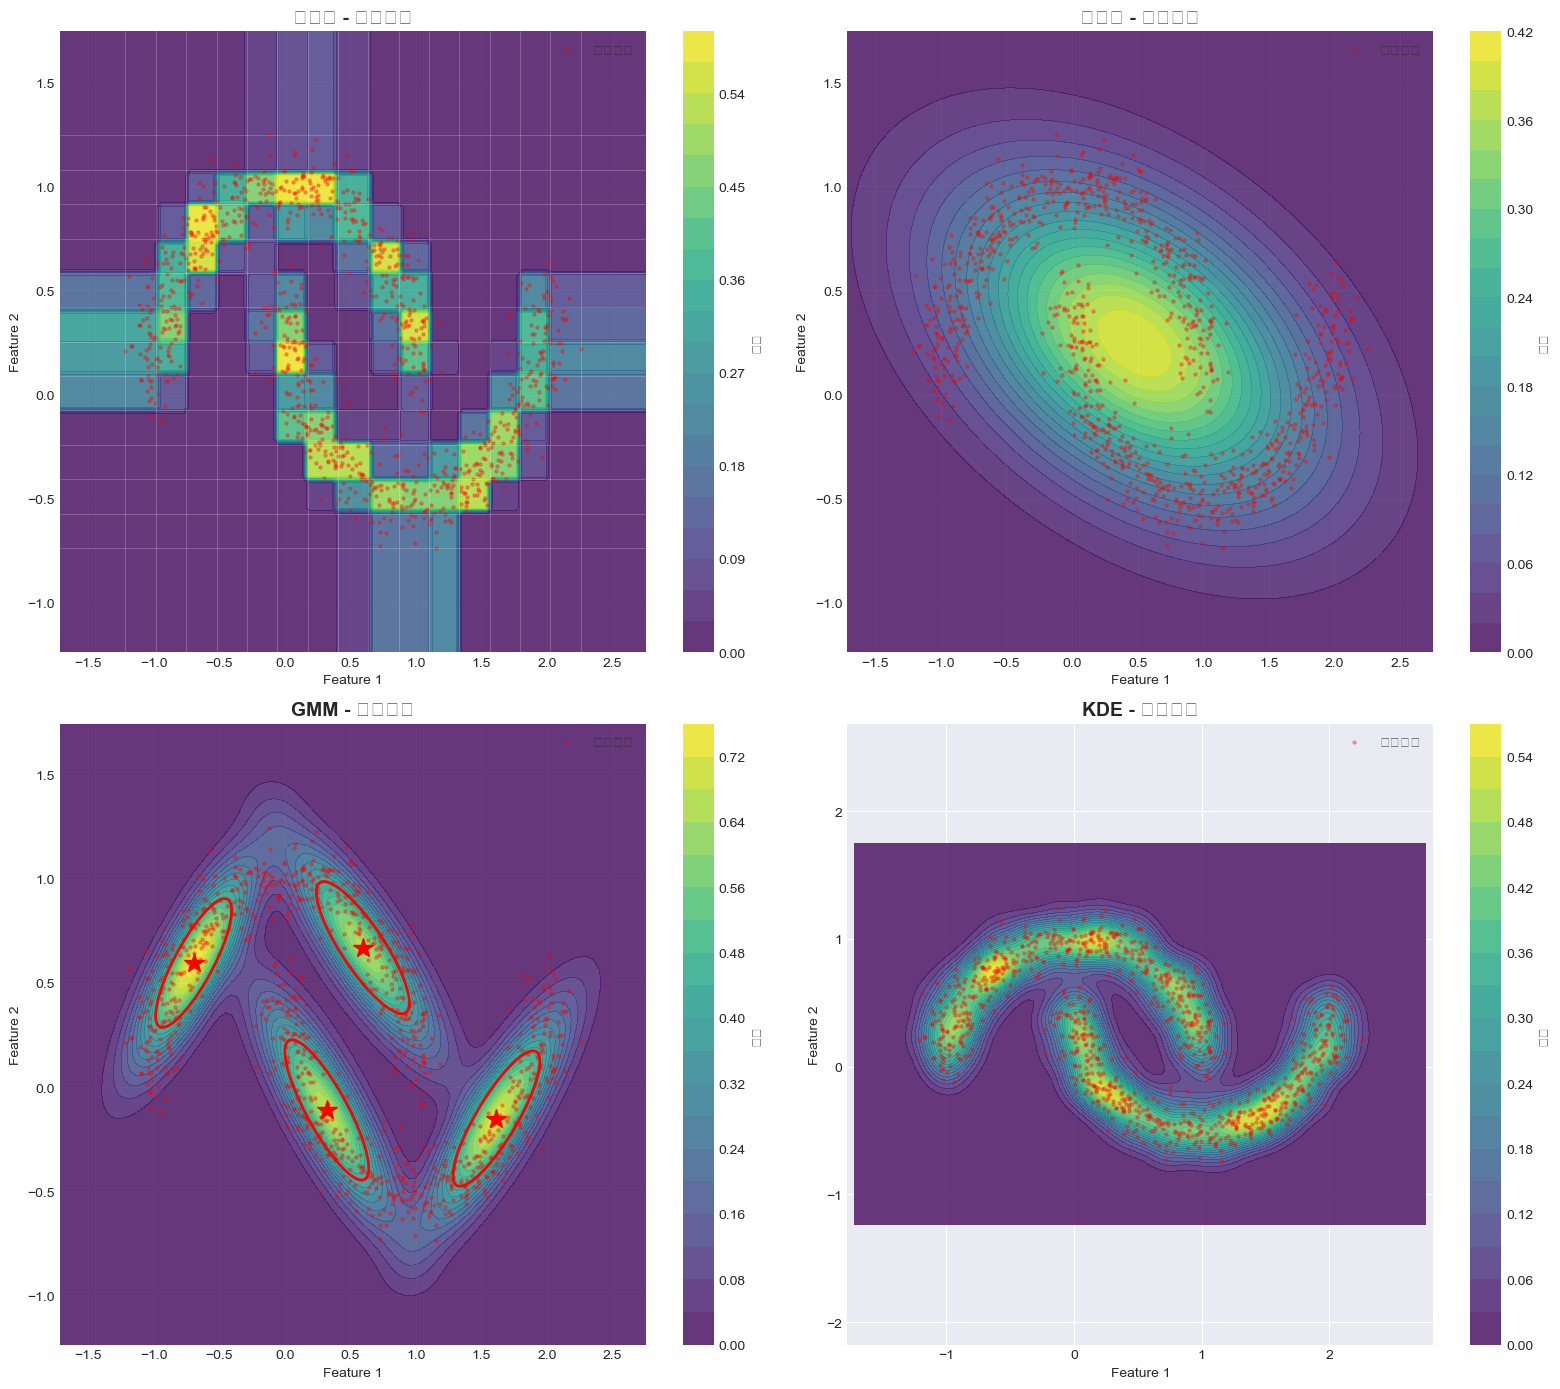

In [9]:
def plot_density(model, model_name, X_train, ax=None):
    """
    可视化密度估计
    
    参数:
        model: 密度模型
        model_name: 模型名称
        X_train: 训练数据
        ax: matplotlib axis对象
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # 创建网格
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 计算密度
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_densities = model.score_samples(grid_points)
    densities = np.exp(log_densities).reshape(xx.shape)
    
    # 绘制密度图
    contour = ax.contourf(xx, yy, densities, levels=20, cmap='viridis', alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c='red', s=5, alpha=0.3, label='训练数据')
    
    # 添加特殊标记
    if model_name == "直方图" and hasattr(model, 'bins_x'):
        # 显示网格线
        for edge in model.bins_x:
            ax.axvline(edge, color='white', alpha=0.3, linewidth=0.5)
        for edge in model.bins_y:
            ax.axhline(edge, color='white', alpha=0.3, linewidth=0.5)
    
    elif isinstance(model, GaussianMixtureModel) and hasattr(model, 'means'):
        # 显示高斯分量
        for k in range(model.n_components):
            # 计算特征值和特征向量
            eigvals, eigvecs = np.linalg.eig(model.covs[k])
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            
            ellipse = Ellipse(model.means[k], width, height, angle=angle,
                            facecolor='none', edgecolor='red', linewidth=2)
            ax.add_patch(ellipse)
            ax.plot(model.means[k][0], model.means[k][1], 'r*', markersize=15)
    
    ax.set_title(f'{model_name} - 密度估计', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    plt.axis('equal')
    ax.legend()
    plt.colorbar(contour, ax=ax, label='密度')
    
    return ax

# 绘制所有模型的密度估计
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

models = [
    (hist_model, "直方图"),
    (sg_model, "单高斯"),
    (gmm_model, "GMM"),
    (kde_model, "KDE")
]

for i, (model, name) in enumerate(models):
    plot_density(model, name, X_train, ax=axes[i])

plt.tight_layout()
plt.show()

### 5.2 sample visualization

/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/314396022.py:24: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/314396022.py:24: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/314396022.py:24: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/314396022.py:24: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipykernel_68598/314396022.py:24: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b0/bfmrglhj5bqglnnb1s6dn7140000gn/T/ipyker

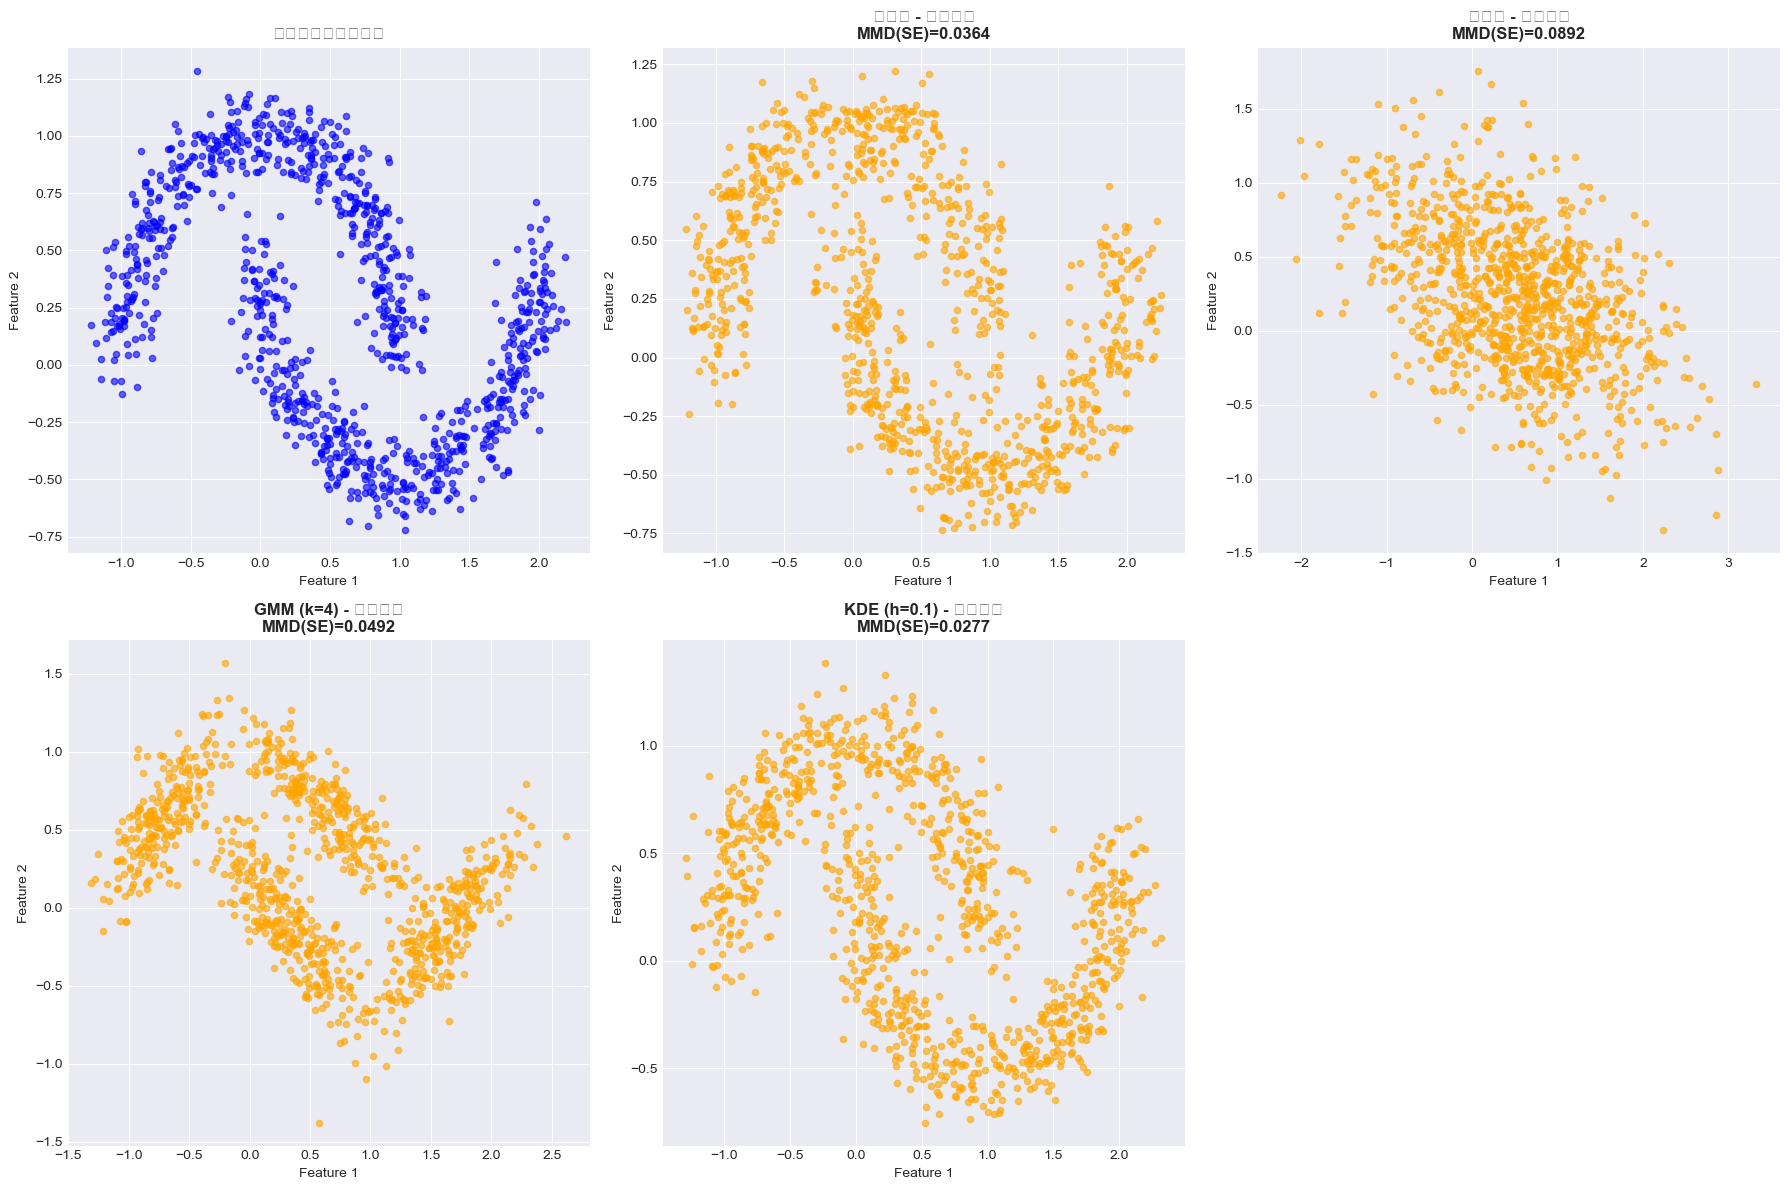

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 原始测试数据
axes[0, 0].scatter(X_test[:, 0], X_test[:, 1], alpha=0.6, s=20, c='blue')
axes[0, 0].set_title('测试集（真实数据）', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

# 各模型生成的样本
for i, result in enumerate(results):
    row = (i + 1) // 3
    col = (i + 1) % 3
    
    X_gen = result['samples']
    axes[row, col].scatter(X_gen[:, 0], X_gen[:, 1], alpha=0.6, s=20, c='orange')
    axes[row, col].set_title(f"{result['model']} - 生成样本\nMMD(SE)={result['mmd_se']:.4f}", 
                            fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Feature 1')
    axes[row, col].set_ylabel('Feature 2')

# 隐藏多余的子图
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

### 6. 超参数影响分析

直方图 - bin数量影响:
使用固定bin数: 5 x 5
  bins=5: MMD(SE)=0.0702, MMD(IMQ)=0.0808
使用固定bin数: 10 x 10
  bins=10: MMD(SE)=0.0381, MMD(IMQ)=0.0337
使用固定bin数: 20 x 20
  bins=20: MMD(SE)=0.0240, MMD(IMQ)=0.0159
使用固定bin数: 30 x 30
  bins=30: MMD(SE)=0.0264, MMD(IMQ)=0.0251
使用固定bin数: 50 x 50
  bins=50: MMD(SE)=0.0257, MMD(IMQ)=0.0203


/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/

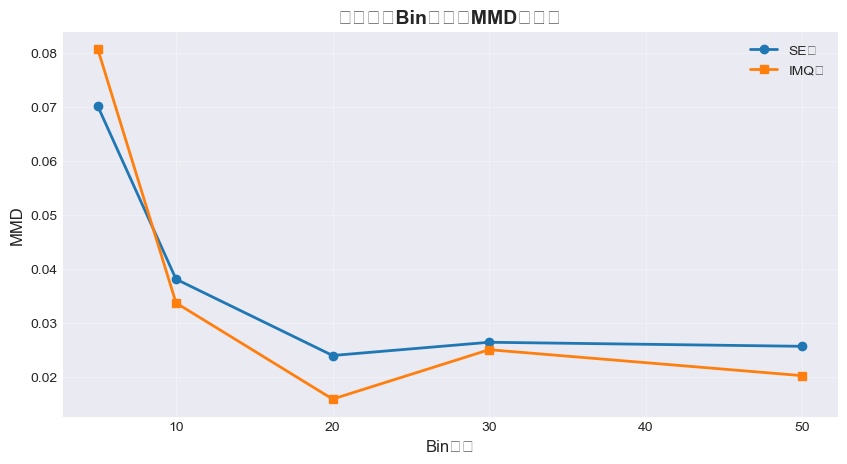

In [11]:
bin_sizes = [5, 10, 20, 30, 50]
mmd_results_hist = {'bins': [], 'mmd_se': [], 'mmd_imq': []}

print("直方图 - bin数量影响:")
for n_bins in bin_sizes:
    model = Histogram(n_bins=n_bins)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_hist['bins'].append(n_bins)
    mmd_results_hist['mmd_se'].append(mmd_se)
    mmd_results_hist['mmd_imq'].append(mmd_imq)

    print(f"  bins={n_bins}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_se'], 'o-', label='SE核', linewidth=2)
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_imq'], 's-', label='IMQ核', linewidth=2)
plt.xlabel('Bin数量', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('直方图：Bin数量对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.2 GMM：分量数的影响


GMM - 分量数影响:
  n_components=2: MMD(SE)=0.0813, MMD(IMQ)=0.1056
GMM收敛于第50次迭代
  n_components=3: MMD(SE)=0.0651, MMD(IMQ)=0.0809
GMM收敛于第67次迭代
  n_components=4: MMD(SE)=0.0536, MMD(IMQ)=0.0610
  n_components=5: MMD(SE)=0.0570, MMD(IMQ)=0.0678
  n_components=6: MMD(SE)=0.0321, MMD(IMQ)=0.0334
GMM收敛于第99次迭代
  n_components=8: MMD(SE)=0.0171, MMD(IMQ)=0.0114


/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


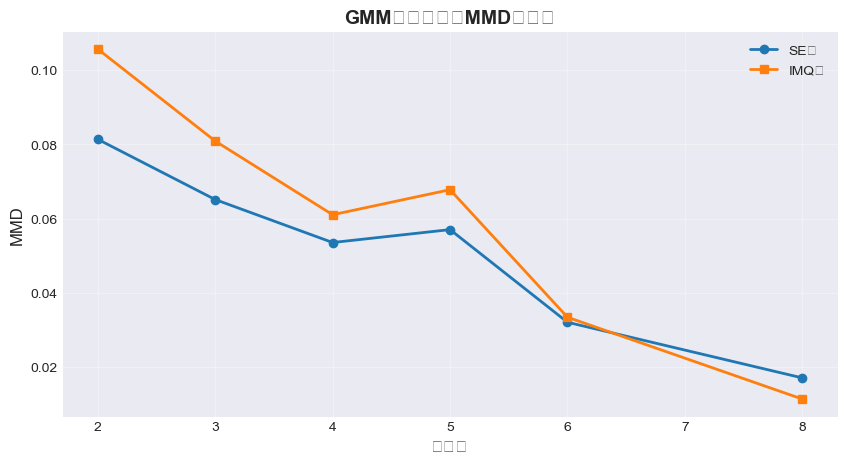

In [12]:
n_components_list = [2, 3, 4, 5, 6, 8]
mmd_results_gmm = {'n_components': [], 'mmd_se': [], 'mmd_imq': []}

print("\nGMM - 分量数影响:")
for n_comp in n_components_list:
    model = GaussianMixtureModel(n_components=n_comp, max_iter=100)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_gmm['n_components'].append(n_comp)
    mmd_results_gmm['mmd_se'].append(mmd_se)
    mmd_results_gmm['mmd_imq'].append(mmd_imq)

    print(f"  n_components={n_comp}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_se'], 'o-', label='SE核', linewidth=2)
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_imq'], 's-', label='IMQ核', linewidth=2)
plt.xlabel('分量数', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('GMM：分量数对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.3 KDE：带宽的影响


KDE - 带宽影响:
  bandwidth=0.1: MMD(SE)=0.0316, MMD(IMQ)=0.0414
  bandwidth=0.2: MMD(SE)=0.0573, MMD(IMQ)=0.0624
  bandwidth=0.3: MMD(SE)=0.0716, MMD(IMQ)=0.0860
  bandwidth=0.5: MMD(SE)=0.0785, MMD(IMQ)=0.1129


/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24102 (\N{CJK UNIFIED IDEOGRAPH-5E26}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23485 (\N{CJK UNIFIED IDEOGRAPH-5BBD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


  bandwidth=0.7: MMD(SE)=0.0902, MMD(IMQ)=0.1414
  bandwidth=1.0: MMD(SE)=0.0937, MMD(IMQ)=0.1776


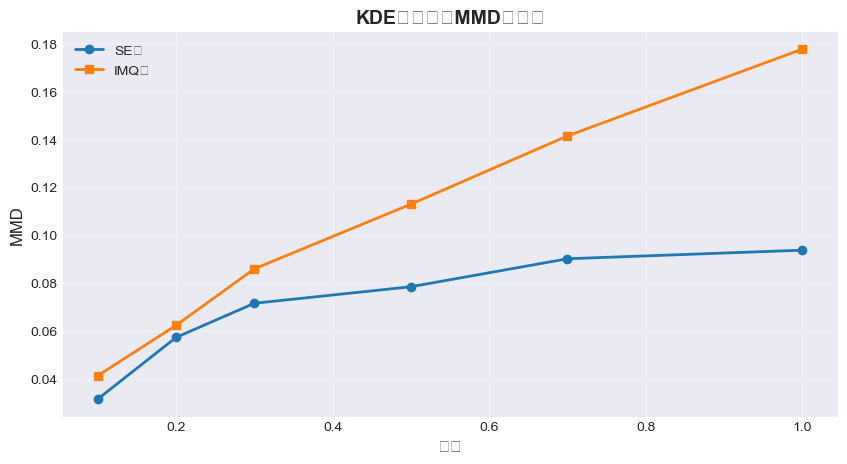

In [13]:
bandwidths = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
mmd_results_kde = {'bandwidth': [], 'mmd_se': [], 'mmd_imq': []}

print("\nKDE - 带宽影响:")
for bw in bandwidths:
    model = KernelDensityEstimator(bandwidth=bw)
    model.fit(X_train)
    X_gen = model.sample(1000)

    mmd_se = compute_mmd(X_test, X_gen, kernel='se', h=0.1)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', h=0.1)

    mmd_results_kde['bandwidth'].append(bw)
    mmd_results_kde['mmd_se'].append(mmd_se)
    mmd_results_kde['mmd_imq'].append(mmd_imq)

    print(f"  bandwidth={bw}: MMD(SE)={mmd_se:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_se'], 'o-', label='SE核', linewidth=2)
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_imq'], 's-', label='IMQ核', linewidth=2)
plt.xlabel('带宽', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('KDE：带宽对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.4 训练集大小的影响


训练集大小影响:
使用固定bin数: 20 x 20
GMM收敛于第30次迭代
  size=100: Hist=0.0719, Gauss=0.0824, GMM=0.0618, KDE=0.0702
使用固定bin数: 20 x 20
  size=300: Hist=0.0445, Gauss=0.0883, GMM=0.0569, KDE=0.0677
使用固定bin数: 20 x 20
  size=500: Hist=0.0321, Gauss=0.0837, GMM=0.0538, KDE=0.0691
使用固定bin数: 20 x 20
  size=1000: Hist=0.0223, Gauss=0.0841, GMM=0.0444, KDE=0.0687
使用固定bin数: 20 x 20
  size=2000: Hist=0.0184, Gauss=0.0889, GMM=0.0552, KDE=0.0695


/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/

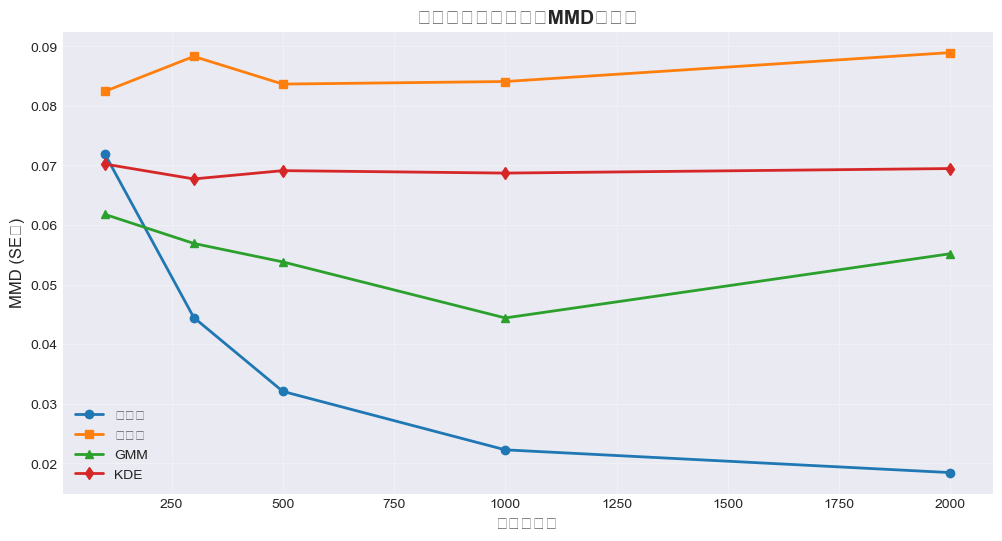

In [14]:
train_sizes = [100, 300, 500, 1000, 2000]
mmd_results_size = {
    'size': [],
    'hist_mmd': [], 'gaussian_mmd': [], 
    'gmm_mmd': [], 'kde_mmd': []
}

print("\n训练集大小影响:")
for size in train_sizes:
    X_train_sub, _ = make_moons(n_samples=size, noise=0.1)
    
    # 直方图
    model_hist = Histogram(n_bins=20).fit(X_train_sub)
    mmd_hist = compute_mmd(X_test, model_hist.sample(1000), kernel='se', h=0.1)
    
    # 单高斯
    model_gauss = SingleGaussian().fit(X_train_sub)
    mmd_gauss = compute_mmd(X_test, model_gauss.sample(1000), kernel='se', h=0.1)

    # GMM
    model_gmm = GaussianMixtureModel(n_components=4, max_iter=50).fit(X_train_sub)
    mmd_gmm = compute_mmd(X_test, model_gmm.sample(1000), kernel='se', h=0.1)

    # KDE
    model_kde = KernelDensityEstimator(bandwidth=0.3).fit(X_train_sub)
    mmd_kde = compute_mmd(X_test, model_kde.sample(1000), kernel='se', h=0.1)

    mmd_results_size['size'].append(size)
    mmd_results_size['hist_mmd'].append(mmd_hist)
    mmd_results_size['gaussian_mmd'].append(mmd_gauss)
    mmd_results_size['gmm_mmd'].append(mmd_gmm)
    mmd_results_size['kde_mmd'].append(mmd_kde)
    
    print(f"  size={size}: Hist={mmd_hist:.4f}, Gauss={mmd_gauss:.4f}, GMM={mmd_gmm:.4f}, KDE={mmd_kde:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(mmd_results_size['size'], mmd_results_size['hist_mmd'], 'o-', label='直方图', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gaussian_mmd'], 's-', label='单高斯', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gmm_mmd'], '^-', label='GMM', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['kde_mmd'], 'd-', label='KDE', linewidth=2)
plt.xlabel('训练集大小', fontsize=12)
plt.ylabel('MMD (SE核)', fontsize=12)
plt.title('训练集大小对各模型MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. 总结与讨论
### 模型性能总结

## 2D Probability Density Estimation Models: An Analysis Summary

This project conducts a systematic analysis and comparison of four classic 2D probability density estimation models:

**Histogram**

**Single Gaussian Model**

**Gaussian Mixture Model (GMM)**

**Kernel Density Estimation (KDE)**

We used the make_moons dataset (noise=0.1) to train the models and employed the Maximum Mean Discrepancy (MMD) as the core evaluation metric. This metric quantifies the goodness-of-fit by comparing the data distribution generated by the model against the true test set.

### 1. Core Findings: Model Performance Comparison

The performance of each model is directly related to its ability to capture the complex bimodal structure of the make_moons dataset.

1st Place: KDE (Kernel Density Estimation)
As a flexible non-parametric method, KDE performed the best. It successfully fit the two crescent shapes of the data, providing a smooth and accurate density estimate.

2nd Place: GMM (Gaussian Mixture Model)
GMM performed exceptionally well. By using multiple Gaussian components (e.g., K=3 or K=4), it was able to effectively approximate the bimodal distribution, achieving results close to KDE.

3rd Place: Histogram
The Histogram's performance was moderate. Its effectiveness is highly dependent on the "bin" (grid) definition. While it roughly captured the two high-density regions, its estimated density is piecewise-constant (non-smooth) and constrained by the grid boundaries.

4th Place: Single Gaussian Model
This model performed the worst. Because make_moons is a bimodal distribution, the Single Gaussian model—which can only model a single, symmetrical, elliptical distribution—was fundamentally unable to capture the true data structure.

### 2. Analysis of Key Influencing Factors

#### 2.1 Hyperparameter Sensitivity

The performance of all models is highly dependent on their key hyperparameters.

KDE (Bandwidth h): This was the most sensitive parameter. The bandwidth h controls the degree of smoothing.

h too small (e.g., 0.1) → Overfitting, resulting in a spiky density map and a high MMD score.

h too large (e.g., 1.0) → Underfitting, resulting in an over-smoothed density that lost the bimodal structure.

The optimal range (h ≈ 0.2 - 0.4) performed best.

GMM (Number of Components K):

When K=1, the model degenerates into a Single Gaussian.

At K=3 or K=4, the MMD score was lowest, striking the best balance between complexity and fit.

With K>6, the model began to overfit the data.

Histogram (Number of Bins):

Too few bins (e.g., 5x5) → Underfitting, resulting in a very coarse density map.

Too many bins (e.g., 50x50) → Overfitting, which paradoxically increased the MMD score.

The automated FD (Freedman-Diaconis) rule or a bin count of 15-25 performed well on this dataset.

#### 2.2 Impact of Training Set Size

The performance of all models improved with more training data (MMD scores decreased).

The Single Gaussian model was the least sensitive to data increases, as its simple structure quickly reached its fitting limit.

KDE and GMM (non-parametric and semi-parametric models) benefited the most from more data. Their MMD scores dropped the most significantly, indicating they are "data-hungry" and can leverage larger datasets to build more accurate distributions.

### 3. A Note on MMD and Kernel Choice

The MMD metric measures the distance between two distributions ($P_{data}$ and $P_{model}$) in a Reproducing Kernel Hilbert Space (RKHS). A lower MMD score indicates that the two distributions are more similar.

The choice of kernel $k(x, y)$ defines the RKHS and is critical, as it determines which differences between distributions are emphasized. This analysis uses two distinct kernels for a more robust evaluation:

RBF (SE) Kernel: $k(x, y) = \exp(-\gamma \|x - y\|^2)$

Characteristic: This is a local kernel. Its influence decays exponentially with distance.

Sensitivity: It is highly sensitive to local, high-frequency differences—such as the precise shape, curvature, and separation of the high-density "moons." A poor fit in the modes of the distribution (the main shapes) will be heavily penalized by the RBF kernel.

IMQ (Inverse Multi-Quadratic) Kernel: $k(x, y) = (c + \|x - y\|^2)^{-\beta}$

Characteristic: This is a global, heavy-tailed kernel. Its influence decays polynomially, much slower than the RBF.

Sensitivity: It is more sensitive to global, low-frequency differences. It places more weight on points that are far apart, making it effective at detecting differences in the tails of the distributions or spotting spurious outliers generated far from the true data.

Conclusion: Using both kernels provides a more complete picture. The RBF kernel ensures the model accurately captures the local shape of the moons, while the IMQ kernel ensures the model captures the global spread and does not generate unrealistic outliers.

### 4. Conclusions and Recommendations

Final Conclusions

There is no "one-size-fits-all" model: Model selection depends on the data's intrinsic structure, the sample size, and the computational budget.

Weighing the Trade-offs:

For complex, irregular distributions like make_moons, KDE provides the highest fitting accuracy.

GMM provides (slightly lower) high accuracy while also offering faster sampling and some interpretability (the K components can be viewed as "clusters").

Hyperparameters are Critical: For GMM and KDE, careful tuning of hyperparameters (K and h) using methods like cross-validation is essential for achieving good performance.

Recommendations for the make_moons Dataset

For Maximum Accuracy: Use KDE and carefully tune the bandwidth h (e.g., h ≈ 0.3).

For Speed and Clustering: Use GMM and select an appropriate K (e.g., K=4).